# Comment démasquer les fraudeurs ? - Challenge BNP PF

## 0. Introduction

Nous avons choisi de participer au challenge Data proposé par BNP Paribas Personal Finance, qui consiste à résoudre le problème de détection de fraudeurs en utilisant le panier client comme source de données. Chaque client est identifié par un ID, et une variable binaire indique si le client est un fraudeur ou non. Nous sommes donc confrontés à un problème de classification.

Pour aborder ce problème, nous avons commencé par réaliser une étude exploratoire approfondie des données, en prenant en compte le volume important du dataset proposé par BNP (92 790 observations et 147 colonnes). Cette étape nous a permis de mieux comprendre les colonnes et le fonctionnement du dataset, ainsi que d'identifier les facteurs pertinents et non pertinents dans la détection de la fraude.

Ensuite, nous avons dû transformer le dataset initial pour construire des features quantitatives, car celui-ci était principalement constitué de variables qualitatives. Cette étape était cruciale pour exploiter pleinement les données et les utiliser dans notre modèle.

Enfin, nous avons construit plusieurs modèles de machine learning, tels que SVM, Kmeans, Random Forest, régression logistique et soft voting classifier. Pour cela, nous nous sommes inspiré des notebooks vus en cours. Cependant, comme vous le verrez les résultats obtenus sont mitigés. Même en réalisant un under-sampling pour équilibrer le nombre d'observations de fraude et de non-fraude, notre modèle n'a pas réussi à prédire de manière idéale les fraudes.

En conclusion, nous avons comparé les résultats de nos modèles en utilisant plusieurs métriques, dont les scores PR auc proposés par le challenge et l'accuracy, ainsi que d'autres métriques qui nous semblaient pertinentes.

L’exucution complète du code est chronophage, nous avions une réelle volonté de ne pas réduire de trop le dataset pour ne pas limité l’apprentissage de notre modèle. De plus, les essaie pour trouver les hyper paramètres sont eux aussi couteux en temps.

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
import re

warnings.filterwarnings('ignore')

In [4]:
df_X_train = pd.read_csv('X_train_G3tdtEn.csv')
df_Y_train = pd.read_csv('Y_train_2_XPXJDyy.csv')

## 1.Analyse exploratoire de données

Tout d'abord, nous allons nous concentrer sur l'analyse de notre dataset de panier client (df_X_train). Nous avons d'ores et déjà identifié les difficultés majeures du projet : la taille du dataset et le fait que les variables soit qualitatives. Avant de réalisé des stats descriptive et de nettoyer le dataset , nous estimons qu'il est essentiel de réaliser une analyse approfondie de ce dernier afin de bien le comprendre et de déterminer les colonnes qui pourraient potentiellement être supprimées.

De plus, nous avons choisi de nous concentrer sur les cas de fraude de clients sur un panier d'articles. Par conséquent, l'analyse des types de paniers (marques présentes, produits achetés, montants dépensés, etc.) peut nous fournir des premières indications avant la création de notre dataset de features.

In [3]:
df_X_train.head()

,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
df_X_train.shape[0]

92790

In [5]:
df_X_train.columns

Index(['ID', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7',
       'item8', 'item9',
       ...
       'Nbr_of_prod_purchas16', 'Nbr_of_prod_purchas17',
       'Nbr_of_prod_purchas18', 'Nbr_of_prod_purchas19',
       'Nbr_of_prod_purchas20', 'Nbr_of_prod_purchas21',
       'Nbr_of_prod_purchas22', 'Nbr_of_prod_purchas23',
       'Nbr_of_prod_purchas24', 'Nb_of_items'],
      dtype='object', length=146)

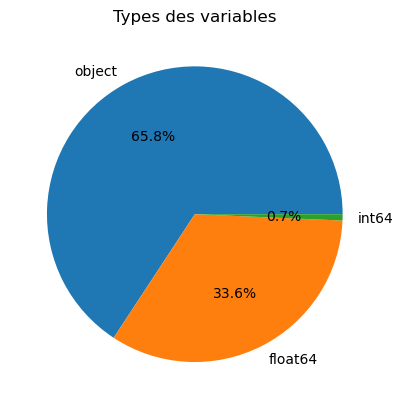

In [6]:
var_count = df_X_train.dtypes.value_counts()

plt.pie(var_count, labels=var_count.index.map(str), autopct='%1.1f%%')
plt.title("Types des variables")
plt.show()

Nous faisons déjà une première constatation, nous avons 146 colonnes et 92790 lignes. Comme on l'évoquait auparavant le dataset est donc gigantesque. De plus, les variables sont majoritairement qualitative dans notre dataset. Ainsi il faudra gérer cela quand on mettre en place nos algorithmes de Machine learning dans la suite du projet.

In [7]:
#Regardons un peu la répartition des données dans le dataset.
nb_NaN=df_X_train.isnull().sum().sort_values(ascending=False)
df_null=pd.DataFrame({'nbre de NaN' : nb_NaN,'% des NaN':(nb_NaN/df_X_train.shape[0])*100})
df_null

,nbre de NaN,% des NaN
make24,92747,99.953659
goods_code24,92747,99.953659
cash_price24,92747,99.953659
Nbr_of_prod_purchas24,92747,99.953659
item24,92747,99.953659
...,...,...
Nbr_of_prod_purchas1,0,0.000000
goods_code1,0,0.000000
item1,0,0.000000
cash_price1,0,0.000000


Text(0.5, 1.0, "Nombre d' items différents acheté par chaque clients")

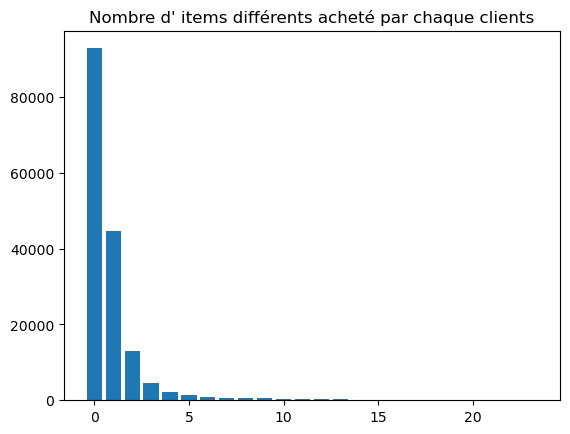

In [8]:
nb_NaN=df_X_train.isnull().sum()
nbr_items=nb_NaN[1:25]
nbr_items=92790-nbr_items
labels=np.arange(24)
plt.bar(labels, nbr_items)
plt.title('Nombre d\' items différents acheté par chaque clients')

Ainsi, cette première analyse nous montre plusieurs choses. Le nombre de colonnes presque vides est substantiel. Cela s'explique car le dataset est fait de telle sorte qu'il y a une colonne par item différent acheté dans la limite de 24 articles différents. Ainsi, on remarque bien que la très grande majorité des clients ont acheté entre 1 et 3 articles différents. En fait, il y a même que 43 clients qui ont acheté 24 articles différents. Pour autant, cela ne représente pas forcément un "outlier". Sans plus amples analyses, on pourrait penser qu'un fraudeur qui sait que ce n'est pas lui qui paie achèterait plus d'articles

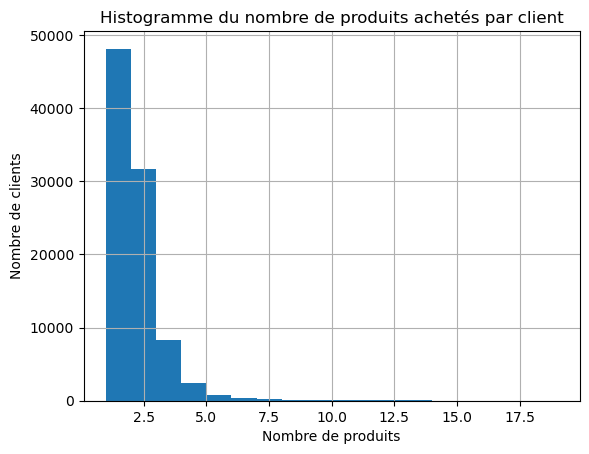

In [9]:
bins=np.arange(1,20)
df_X_train['Nb_of_items'].hist(bins=bins)

plt.title('Histogramme du nombre de produits achetés par client')
plt.xlabel('Nombre de produits')
plt.ylabel('Nombre de clients')

plt.show()

Ainsi le nombre de colonnes presque vide est substantielle. Cela s'explique car le dataset est fait de tel sorte qu'il y a une colonne par item différent acheté dans la limite de 24 items différents. Ainsi on remarque bien que la très très grande majorité des clients ont achetés entre 1 et 3 articles différents. En fait il y'a même que 43 clients qui ont acheté 24 articles différents. Pour autant cela ne représente pas forcément un "outlier". Sans de plus ample analyse on pourrait penser qu'un fraudeur qui sait que c'est n'est pas lui qui paye acheterai plus d'articles.

In [10]:
#On s'intéresse désormais aux marques priviligié par les consomateurs
counts = df_X_train.iloc[:, 50:73].apply(pd.Series.value_counts).sum(axis=1)
brands_df = pd.DataFrame({'brand': counts.index, 'count': counts.values})

# Calculer le pourcentage d'apparition de chaque marque
brands_df['percent'] = brands_df['count'] / len(df_X_train) * 100

brands_df.sort_values('percent', ascending=False, inplace=True)
brands_df = brands_df.set_index(brands_df.columns[0])

print("Le nombre de marques différentes est : " + str(brands_df.shape[0]))
brands_df


Le nombre de marques différentes est : 753


,count,percent
brand,,
RETAILER,45660.0,49.207889
APPLE,12641.0,13.623235
ANYDAY RETAILER,1958.0,2.110141
SAMSUNG,386.0,0.415993
LG,335.0,0.361030
...,...,...
CARHARTT WIP,1.0,0.001078
CARDS AGAINST HUMANITY,1.0,0.001078
LIDO,1.0,0.001078


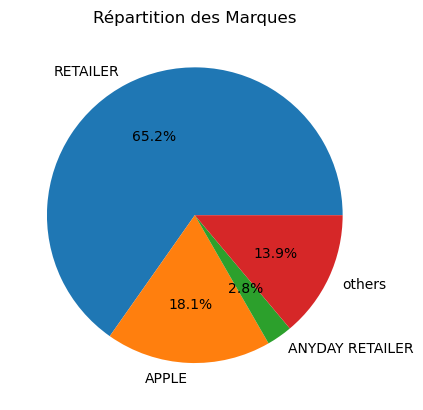

In [11]:
top_brands = counts.nlargest(3)

new_df = pd.DataFrame(top_brands)
new_df.index.name = 'Brand'
new_df.columns = ['Count']
other_count = counts.sum() - top_brands.sum()
new_df.loc['others'] = other_count

plt.pie(new_df.iloc[:,0],labels=new_df.index.map(str), autopct='%1.1f%%')
plt.title("Répartition des Marques")
plt.show()

ON remarque donc que peu de personnes ont des paniers de 24 items et que la majorité des marques sont en quelques sorte indéfini "retailer". La marque la plus présente est donc apple. Cela peut avoir une importance car on a l'intuition que les fraudeurs iront probablement vers les marques chère types Apple

In [12]:
#On s'intéresse désormais aux produits priviligié par les consomateurs
counts = df_X_train.iloc[:, 1:25].apply(pd.Series.value_counts).sum(axis=1)
product_df = pd.DataFrame({'Product': counts.index, 'count': counts.values})

# Calculer le pourcentage d'apparition de chaque produits
product_df['percent'] = product_df['count'] / len(df_X_train) * 100

product_df.sort_values('percent', ascending=False, inplace=True)
product_df = product_df.set_index(product_df.columns[0])

print("Le nombre de produits différents est : " + str(product_df.shape[0]))
product_df

Le nombre de produits différents est : 173


,count,percent
Product,,
COMPUTERS,50221.0,54.123289
FULFILMENT CHARGE,25023.0,26.967346
COMPUTER PERIPHERALS ACCESSORIES,17418.0,18.771419
TELEVISIONS HOME CINEMA,14051.0,15.142796
WARRANTY,8213.0,8.851169
...,...,...
HOME SAFETY EQUIPMENT,1.0,0.001078
MEN S SPORTSWEAR,1.0,0.001078
TECHNOLOGY ACCESSORIES,1.0,0.001078


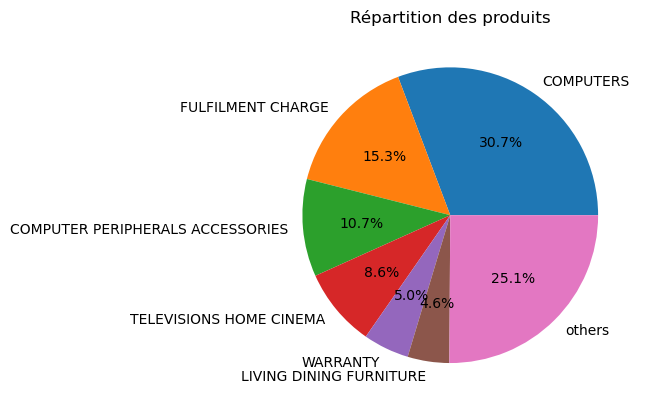

In [13]:
top_product = counts.nlargest(6)

new_df = pd.DataFrame(top_product)
new_df.index.name = 'Product'
new_df.columns = ['Count']
other_count = counts.sum() - top_product.sum()
new_df.loc['others'] = other_count

plt.pie(new_df.iloc[:,0],labels=new_df.index.map(str), autopct='%1.1f%%')
plt.title("Répartition des produits")
plt.show()

Ainsi nous remarquons qu'il y'a 753 marques différentes pour 173 produits différents.Premier point d' attention la marques principal est catalogué comme "retailer" c'est en fait une sorte de maques indéfinis qui peut regrouper beaucoup de marques différentes réelles en son sein. Donc la marque la plus vendu est sans grande surprise apple et les produits les plus achetés sont les ordinateurs. Nous remarquons aussi l'apparition de fulfilement charge ce terme regroupe beaucoup de frais indirect a une commande (création de site e commerce, préparation de set up...)
Ce projet est proposé par bnp personal finance est regroupe donc plusieurs entités de crédits a la conso. Ainsi si on peut supposer qu'un client "honnete" peut avoir tendance a avoir des fulfilement charge pour la création d'un site ou un lancement de projet cela semble moin probable pour un fraudeurs. De plus, notre deuxième intuition est que les fraudeurs auront plus tendance à acheter des produits apple que des produits sous marques. On essaiera de le vérifier ensuite en regarant les liens entre variables de X et Y, pour autant cela ne ser pas simple, car on peut supposer que le fraudeur se tournera vers les "retailers" pour acheter ces produits apple afin d'éviter toutes traces de transaction direct. 

In [14]:
df_X_train.set_index('ID', inplace=True)


In [15]:
df_prix_item=df_X_train.iloc[:, 24:48]
#df_prix_item.index=df_X_train.index
df_prix_item
df_nbr_item=df_X_train.iloc[:, 120:144]
prod = df_nbr_item.to_numpy() * df_prix_item.to_numpy()
arr_no_nan = np.nan_to_num(prod, nan=0)
sum_prod = np.sum(arr_no_nan, axis=1)
df_prix_total = pd.DataFrame({'Prix total': sum_prod}, index=df_nbr_item.index)


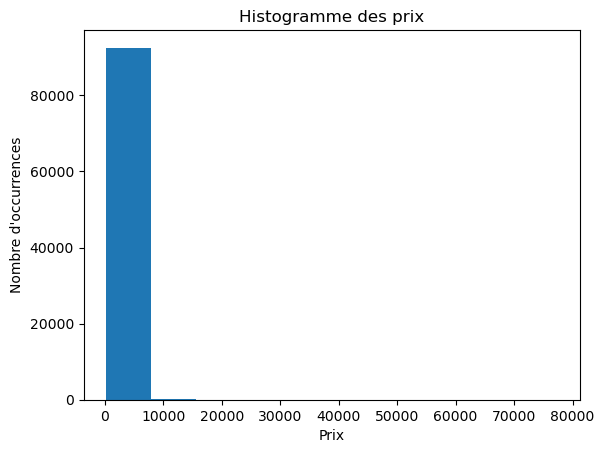

In [16]:
plt.hist(df_prix_total['Prix total'])

# ajouter des labels et un titre au graphique
plt.xlabel('Prix')
plt.ylabel('Nombre d\'occurrences')
plt.title('Histogramme des prix')

# afficher le graphique
plt.show()

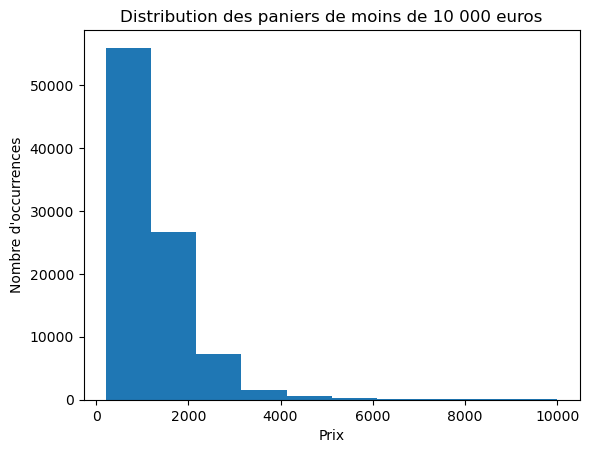

In [17]:
#On remarque que la très grande majorité des commandes sont inferieur à 10 000 euros ce qui est logique pour un crédit à la consomation 
#innéressons nous à la distribution des prix inferieur à 10 000 euros désormais 
df_less_10000 = df_prix_total.loc[df_prix_total['Prix total'] < 10000]

plt.hist(df_less_10000['Prix total'])

# ajouter des labels et un titre au graphique
plt.xlabel('Prix')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des paniers de moins de 10 000 euros')

# afficher le graphique
plt.show()

In [18]:
moyenne_prix=df_prix_total['Prix total'].mean()
print("La moyenne des prix est : ", moyenne_prix)

La moyenne des prix est :  1295.3316844487551


Ainsi, il a été observé que la grande majorité des commandes sont inférieures à 10 000 euros, ce qui est cohérent avec un crédit à la consommation. En effet, les prix des paniers sont majoritairement inférieurs à 2000 euros, avec un panier moyen s'élevant à 1295 euros. Cette tendance est en corrélation avec le fait que les produits Apple, tels que les ordinateurs et les téléphones, soient les plus achetés et soient dans cette gamme de prix.

# Analyse de la variable de sortie Y et mise en relation avec celle d'entrée X

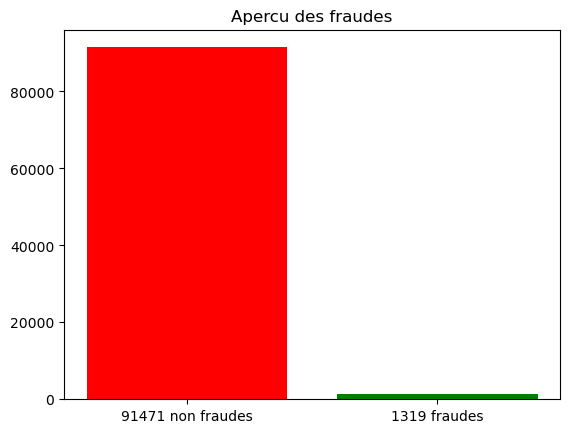

Pourcentage de fraudes reportés : 1.4214893846319647 %


In [19]:
fraud_flags = df_Y_train['fraud_flag']
values, counts = np.unique(fraud_flags, return_counts=True)
lab_1=str(counts[0]) + " non fraudes"
lab_2=str(counts[1])+ " fraudes"
labels = [lab_1, lab_2]
colors = ['red', 'green']
plt.bar(labels, counts, color=colors)
plt.title(f"Apercu des fraudes")
plt.show()
print('Pourcentage de fraudes reportés :', 100*counts[1]/(counts[0]+counts[1]),'%')

In [20]:
df_Y_train.set_index('ID', inplace=True)


In [21]:
df_Y_train

,index,fraud_flag
ID,,
85517,0,0
51113,1,0
83008,2,0
78712,3,0
77846,4,0
...,...,...
21243,92785,0
45891,92786,0
42613,92787,0


In [22]:
df_nbr_items=df_X_train['Nb_of_items']
df_fraude=df_Y_train['fraud_flag']

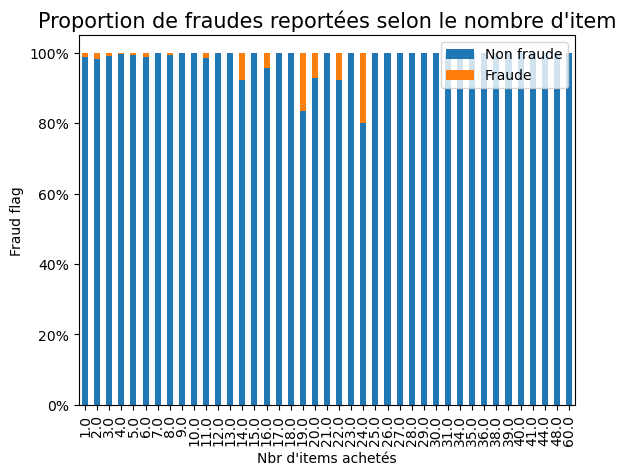

In [23]:
graphe=pd.crosstab(df_nbr_items, df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon le nombre d\'item', fontsize=15)
plt.xlabel('Nbr d\'items achetés')
plt.ylabel('Fraud flag')
plt.show()

Cette première analyse est intéressante, car elle nous révèle que le nombre de fraudes signalées représente environ 20% des paniers comportant 24 articles. De plus, nous avons remarqué que le nombre de fraudes signalées pour les paniers contenant plus de 26 articles semble négligeable. Nous pouvons également constater que le nombre de fraudes est très faible par rapport aux non-fraudes : seulement 1,421%. C'est pourquoi nous utiliserons une technique d'undersampling avant de procéder à l'entraînement de nos modèles.

In [24]:
#Afin d'avoir une vue un peu plus globale sur les relations entre marques et fraudes 
#nous allons réalisé un tableau de contingence
df_marques=df_X_train.iloc[:, 48:72]

def get_top_brand(row):
    if 'APPLE' in row.values:
        return 'Apple'
    elif 'SAMSUNG' in row.values:
        return 'Samsung'
    elif 'LG' in row.values:
        return 'LG'
    elif 'RETAILER' in row.values:
        return 'Retailer'
    else:
        return 'Others'

new_df_marques = df_marques.apply(get_top_brand, axis=1).rename("Marques")


tableau_contingence=pd.DataFrame( pd.crosstab(new_df_marques, 
                                 df_fraude,  
                                 margins = True) ) 
tableau_contingence

fraud_flag,0,1,All
Marques,,,
Apple,63208,1191,64399
LG,8190,17,8207
Others,6173,24,6197
Retailer,9213,24,9237
Samsung,4687,63,4750
All,91471,1319,92790


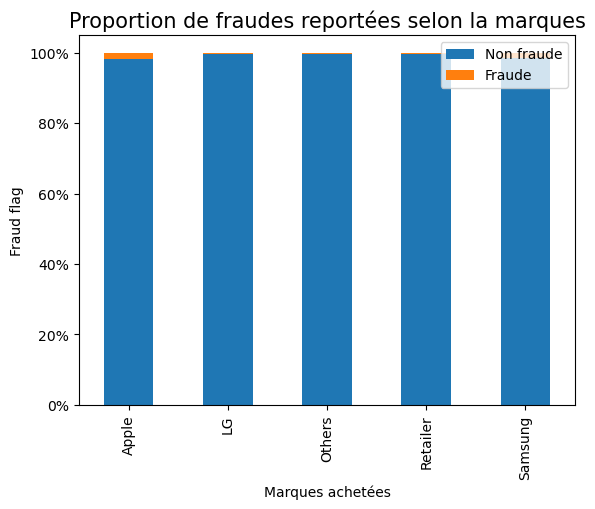

In [25]:
graphe=pd.crosstab(new_df_marques,df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon la marques', fontsize=15)
plt.xlabel('Marques achetées')
plt.ylabel('Fraud flag')
plt.show()

Ce qui est intéressant à voir c'est qu'il semble y avoir plus de fraudes avec au moins un produit apple ou samsung. Meme si les proportions sont très faible cela donne déjà une belle indication. Les variables 'marques' jouent donc probablement un roles. Les proportions sont plus faibles pour les "retailers" qui sont donc probablement moin visé par les escrocs.

In [26]:
df_produits=df_X_train.iloc[:, 0:1]

def get_top_prod(row):
    if 'COMPUTERS' in row.values:
        return 'COMPUTERS'
    elif 'FULFILMENT CHARGE' in row.values:
        return 'FULFILMENT CHARGE '
    elif 'COMPUTER PERIPHERALS ACCESSORIES' in row.values:
        return 'COMPUTER PERIPHERALS ACCESSORIES'
    elif 'TELEVISIONS HOME CINEMA' in row.values:
        return 'TELEVISIONS HOME CINEMA '
    else:
        return 'Others'

new_df_produits = df_produits.apply(get_top_prod, axis=1).rename("Produits")

#new_df_produits = df_produits
tableau_contingence2=pd.DataFrame( pd.crosstab(new_df_produits, 
                                 df_fraude,  
                                 margins = True) ) 
tableau_contingence2

fraud_flag,0,1,All
Produits,,,
COMPUTER PERIPHERALS ACCESSORIES,11751,36,11787
COMPUTERS,46370,1066,47436
Others,19969,168,20137
TELEVISIONS HOME CINEMA,13381,49,13430
All,91471,1319,92790


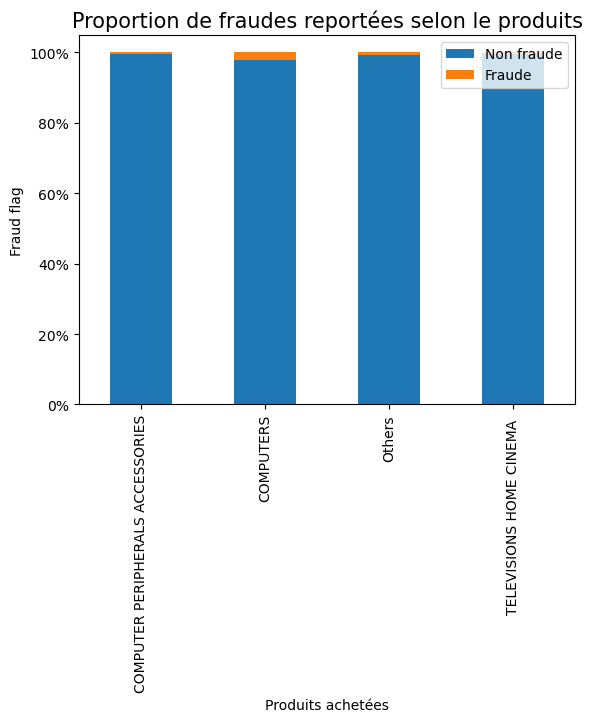

In [27]:
graphe=pd.crosstab(new_df_produits,df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon le produits', fontsize=15)
plt.xlabel('Produits achetées')
plt.ylabel('Fraud flag')
plt.show()

De la même façon que pour les marques, nous constatons que les produits qui sont le plus sujets à la fraude sont les ordinateurs. Cela confirme nos précédentes intuitions

# Statistiques descriptives & Data cleaning

Dans cette partie, nous allons tout d'abord effectuer quelques analyses statistiques sur notre jeu de données sachant que nous avons affaire à des variables qualitatives. Ensuite, nous allons procéder à une transformation de notre jeu de données afin de le rendre utilisable pour nos modèles.

In [28]:
# commencons par regarder l'argent dépenser selon le nombre d'articles
df_prix_item.describe()

,cash_price1,cash_price2,cash_price3,cash_price4,cash_price5,cash_price6,cash_price7,cash_price8,cash_price9,cash_price10,...,cash_price15,cash_price16,cash_price17,cash_price18,cash_price19,cash_price20,cash_price21,cash_price22,cash_price23,cash_price24
count,92790.000000,44656.000000,12901.000000,4562.000000,2170.00000,1336.000000,946.000000,727.000000,568.000000,472.00000,...,193.000000,165.000000,142.000000,120.000000,103.000000,91.000000,77.000000,63.000000,50.000000,43.000000
mean,1093.907124,191.608071,193.334548,176.132398,195.73871,162.015719,144.598309,130.957359,132.609155,111.57839,...,72.383420,98.230303,89.014085,83.958333,88.184466,79.615385,58.194805,125.777778,108.540000,121.744186
std,711.172270,392.665621,375.676640,321.354938,374.22739,292.077355,291.432858,257.730692,267.234057,213.05103,...,106.357486,227.905699,177.078097,133.670132,142.225018,222.555699,88.780041,341.952102,198.611734,263.623477
min,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,4.000000
25%,649.000000,7.000000,7.000000,10.000000,16.00000,15.000000,20.000000,16.000000,18.000000,15.00000,...,13.000000,16.000000,14.250000,12.000000,18.000000,13.000000,9.000000,12.000000,12.250000,9.000000
50%,949.000000,40.000000,43.000000,48.000000,59.00000,50.000000,50.000000,45.000000,45.000000,40.00000,...,35.000000,35.000000,30.000000,25.000000,36.000000,26.000000,25.000000,28.000000,35.000000,20.000000
75%,1349.000000,139.000000,189.000000,189.000000,199.00000,179.250000,140.000000,120.000000,129.250000,96.00000,...,72.000000,80.000000,89.500000,102.000000,95.500000,55.000000,54.000000,72.000000,86.750000,69.500000
max,21995.000000,6499.000000,5999.000000,5198.000000,4249.00000,2997.000000,4198.000000,2999.000000,2399.000000,1545.00000,...,599.000000,1599.000000,1550.000000,799.000000,999.000000,2010.000000,450.000000,2090.000000,995.000000,1045.000000


In [29]:
df_prix_total.describe()

,Prix total
count,92790.000000
mean,1295.331684
std,1075.861734
min,219.000000
25%,781.000000
50%,1099.000000
75%,1528.000000
max,77355.000000


Desormais nous aimerions bien savoir si le prix total dépenser par le client est une variable qui joue en termes statistiques sur la variables cible. 
Ici nous comparons variables qualitatives et quantitatives, ainsi faire une corrélation de type de Perason n'a que peu de sens, afin de regarder de plus proche si Prix et fraudes sont liés nous allons faire un test de Mann-Whitney 
On utilise donc des test alternatifs

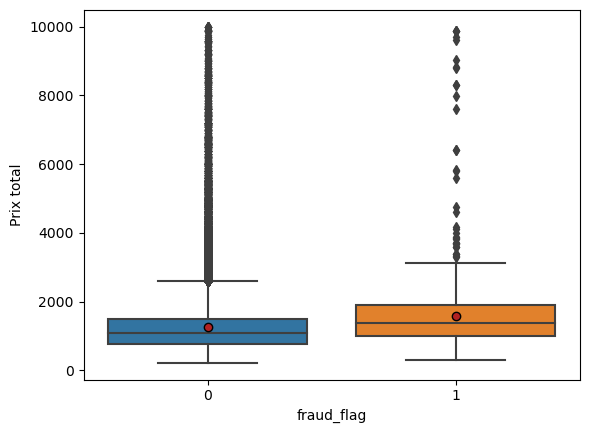

In [30]:
df_prix_fraude=df_prix_total.join(df_fraude,how='inner')
df_prix_fraude = df_prix_fraude.loc[df_prix_fraude['Prix total'] < 10000]
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'} 
sns.boxplot(y='Prix total', x='fraud_flag', data=df_prix_fraude, showmeans=True, meanprops=meanprops) 
plt.show()

On remarque donc que les prix totaux ont l'air légèrement inférieurs pour les cas de non fraudes, néanmoins, y a-t-il un lien direct entre les deux variables ? Les moyennes (point rouge) ne semblent pas réellement différentes. Nous aimerions bien savoir si le prix total dépensé par le client est une variable qui joue en termes statistiques sur la variable cible. Ici, nous comparons des variables qualitatives et quantitatives. Faire une corrélation de type Pearson n'a que peu de sens dans ce cas. Afin de vérifier si le prix et la fraude sont liés, nous allons effectuer un test de Mann-Whitney, qui est un test non paramétrique utilisé pour comparer les moyennes de deux échantillons.

In [31]:
df_prix_fraude = df_prix_fraude.loc[df_prix_fraude['Prix total'] < 10000]

In [32]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df_prix_fraude['Prix total'], df_prix_fraude['fraud_flag'], alternative='two-sided')

# Afficher le résultat
print('Statistique de test :', stat)
print('Valeur p :', p)

Statistique de test : 8588470276.0
Valeur p : 0.0


La p value est très faible (0,0), ce qui suggère que les différences observées sont très peu probablement dues au hasard. On peut donc conclure que le prix est une variable significative pour prédire les fraudes c'est pour cela qu'on va donner une place importante aux prix dans la construction du dataset.

In [33]:
df_nbr_items=df_nbr_items.to_frame()
df_nbr_items.describe()

,Nb_of_items
count,92790.000000
mean,1.764479
std,1.462264
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,60.000000


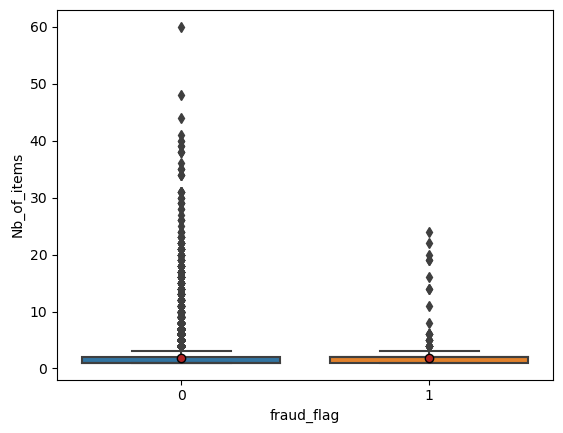

In [34]:
df_item_fraude=df_nbr_items.join(df_fraude,how='inner')
#df_item_fraude = df_item_fraude.loc[df_item_fraude['Nb_of_items'] < 10]
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'} 
sns.boxplot(y='Nb_of_items', x='fraud_flag', data=df_item_fraude, showmeans=True, meanprops=meanprops) 
plt.show()

In [35]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df_item_fraude['Nb_of_items'], df_item_fraude['fraud_flag'], alternative='two-sided')

# Afficher le résultat
print('Statistique de test :', stat)
print('Valeur p :', p)

Statistique de test : 8578239727.0
Valeur p : 0.0


In [36]:
chi2, pvalue= chi2_contingency(tableau_contingence)[0:2]
print("Statistique de test observée",chi2)
print("p-value du test :", pvalue)

Statistique de test observée 307.08273980146953
p-value du test : 4.942061399173584e-60


In [37]:
chi2, pvalue= chi2_contingency(tableau_contingence2)[0:2]
print("Statistique de test observée",chi2)
print("p-value du test :", pvalue)

Statistique de test observée 492.1522219809444
p-value du test : 3.3951994224735024e-101


## 2. Traitement des données

Nous allons désormais nettoyer le dataset et le mettre au format souhaité pour nos modèles. Tout d'abord, nous allons enlever les colonnes que nous jugeons inutiles, à savoir :

goods_code
model
ID
Nb_of_items

Au vu des analyses précédentes, nous décidons de garder et de réarranger les données en features que l'on juge pertinentes. Nous gardons les éléments clés tels que la quantité et les prix par marque achetées et produits achetés.

Le code prend du temps à s'exécuter pour la construction du dataset, etant donné le grand nombre de colonnes considérées.

In [277]:
df = pd.read_csv('X_train_G3tdtEn.csv')

dtypes = df.dtypes

cols = df.columns

for col in cols:
    if "goods_code" in col or "model" in col or "ID" in col or col == 'Nb_of_items':
        df.drop(col, axis=1, inplace=True)

cols = df.columns

df.fillna('', inplace=True)

df.head()

,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,...,Nbr_of_prod_purchas15,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24
0,COMPUTERS,,,,,,,,,,...,,,,,,,,,,
1,COMPUTER PERIPHERALS ACCESSORIES,,,,,,,,,,...,,,,,,,,,,
2,TELEVISIONS HOME CINEMA,,,,,,,,,,...,,,,,,,,,,
3,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,,,,,,,,,...,,,,,,,,,,
4,TELEVISIONS HOME CINEMA,,,,,,,,,,...,,,,,,,,,,


Nous allons maintenant répertorier l'ensembles des marques et produits présents dans les données du dataset de BNP Paris

In [314]:
unique_values = {}
feature_cols = {}
feature_df = {}
features = ['item', 'price', 'make', 'purchas']

def remove_numbers(string):
    pattern = r'\d+' 
    result = re.sub(pattern, '', string)
    return result

for feature in features:
    unique_values[feature] = []
    feature_cols[feature] = []
    
    for col in cols:
        if feature in col:
            feature_cols[feature].append(col)
    
    feature_df[feature] = df[feature_cols[feature]]
        
    if feature == 'item' or feature == 'make':  
        
        feature_df[feature] = feature_df[feature].apply(lambda x: x.str.replace(' ', ''))
        feature_df[feature] = feature_df[feature].apply(lambda x: x.str.replace('&', ''))
        feature_df[feature] = feature_df[feature].apply(lambda x: x.str.replace(',', ''))
        feature_df[feature] = feature_df[feature].apply(lambda x: x.str.replace('-', ''))
        
        feature_df[feature] = feature_df[feature].applymap(remove_numbers)  
        
        for i, row in feature_df[feature].iterrows():
            for val in row:
                if val != '':
                    if val not in unique_values[feature]:
                        unique_values[feature].append(val)
              
print(unique_values)

{'item': ['COMPUTERS', 'COMPUTERPERIPHERALSACCESSORIES', 'TELEVISIONSHOMECINEMA', 'SERVICE', 'FULFILMENTCHARGE', 'CABLESADAPTERS', 'BEDROOMFURNITURE', 'LIVINGDININGFURNITURE', 'WARRANTY', 'TELEPHONESFAXMACHINESTWOWAYRADIOS', 'BABYCHILDTRAVEL', 'STANDSBRACKETS', 'HOMEOFFICE', 'LIGHTING', 'OUTDOORFURNITURE', 'SOFTFURNISHINGS', 'AUDIOACCESSORIES', 'BATHROOMACCESSORIES', 'TABLEWARE', 'WINDOWDRESSING', 'BARBECUESACCESSORIES', 'OUTDOORACCESSORIES', 'POWERBATTERIES', 'BEDLINEN', 'HEALTHBEAUTYELECTRICAL', 'BAGSCARRYCASES', 'HOUSEHOLDCLEANING', 'FOODPREPARATION', 'COOKWARE', 'HIFI', 'CARPETSRUGSFLOORING', 'STORAGEORGANISATION', 'BATHLINEN', 'KITCHENUTENSILSGADGETS', 'DECORATIVEACCESSORIES', 'DECORATING', 'HEATINGCOOLINGAPPLIANCES', 'KITCHENSTORAGE', 'LAUNDRYCLOTHESCARE', 'BABYFEEDING', 'BABYWEAR', 'BABYCHANGING', 'HOTDRINKPREPARATION', 'NURSERYFURNITURE', 'WOMENSFOOTWEAR', 'WOMENSCLOTHES', 'DRESSMAKING', 'COMPUTERSOFTWARE', 'BATHBODYCARE', 'TELEPHONEACCESSORIES', 'FITTEDKITCHENS', 'KITCHENACCES

Les colonnes finales de notre dataset vont devenir les prix et le nombre par achat de l'ensemble des éléments présents dans la liste ci-dessus (ce sont les différentes marques, et types d'items).

In [315]:
new_cols = []

for feature in features:
    if feature == 'item' or feature == 'make':       
        for label_add_up in [' Number', ' Price']:
            for val in unique_values[feature]:
                new_cols.append(val + label_add_up)

new_cols

['COMPUTERS Number',
 'COMPUTERPERIPHERALSACCESSORIES Number',
 'TELEVISIONSHOMECINEMA Number',
 'SERVICE Number',
 'FULFILMENTCHARGE Number',
 'CABLESADAPTERS Number',
 'BEDROOMFURNITURE Number',
 'LIVINGDININGFURNITURE Number',
 'WARRANTY Number',
 'TELEPHONESFAXMACHINESTWOWAYRADIOS Number',
 'BABYCHILDTRAVEL Number',
 'STANDSBRACKETS Number',
 'HOMEOFFICE Number',
 'LIGHTING Number',
 'OUTDOORFURNITURE Number',
 'SOFTFURNISHINGS Number',
 'AUDIOACCESSORIES Number',
 'BATHROOMACCESSORIES Number',
 'TABLEWARE Number',
 'WINDOWDRESSING Number',
 'BARBECUESACCESSORIES Number',
 'OUTDOORACCESSORIES Number',
 'POWERBATTERIES Number',
 'BEDLINEN Number',
 'HEALTHBEAUTYELECTRICAL Number',
 'BAGSCARRYCASES Number',
 'HOUSEHOLDCLEANING Number',
 'FOODPREPARATION Number',
 'COOKWARE Number',
 'HIFI Number',
 'CARPETSRUGSFLOORING Number',
 'STORAGEORGANISATION Number',
 'BATHLINEN Number',
 'KITCHENUTENSILSGADGETS Number',
 'DECORATIVEACCESSORIES Number',
 'DECORATING Number',
 'HEATINGCOOLINGA

On obtient ici la liste des nouvelles colonnes de notre future dataset traité. On va maintenant créer des dictionnaires pour: le nombre acheté par item, le prix par item, le nombre acheté par marque et le prix d'achat par marque.

In [316]:
count_item = {}
count_make = {}
price_item = {}
price_make = {}

for i, row in feature_df['item'].iterrows():
    count_item[i] = {}
    price_item[i] = {}
    
    for item in unique_values['item']:
        count_item[i][f'{item} Number'] = 0
        price_item[i][f'{item} Price'] = 0
    
    for index, val in row.iteritems():
        if val != '':
            i_th = re.sub("[^0-9]", "", index)
            count_item[i][f'{val} Number'] += float(feature_df['purchas'][f'Nbr_of_prod_purchas{i_th}'][i])
            price_item[i][f'{val} Price'] += float(feature_df['price'][f'cash_price{i_th}'][i])


In [317]:
for i, row in feature_df['make'].iterrows():
    count_make[i] = {}
    price_make[i] = {}
    
    for make in unique_values['make']:
        count_make[i][f'{make} Number'] = 0
        price_make[i][f'{make} Price'] = 0
    
    for index, val in row.iteritems():
        if val != '':
            i_th = re.sub("[^0-9]", "", index)
            count_make[i][f'{val} Number'] += float(feature_df['purchas'][f'Nbr_of_prod_purchas{i_th}'][i])
            price_make[i][f'{val} Price'] += float(feature_df['price'][f'cash_price{i_th}'][i])

A partir de ces dictionaires, on va constituer un dataframe par dictionaire et ensuite les fusionner pour constituer notre dataset final.

In [318]:
df_count_item = pd.DataFrame.from_dict(count_item, orient='index')

df_count_item.head()

,COMPUTERS Number,COMPUTERPERIPHERALSACCESSORIES Number,TELEVISIONSHOMECINEMA Number,SERVICE Number,FULFILMENTCHARGE Number,CABLESADAPTERS Number,BEDROOMFURNITURE Number,LIVINGDININGFURNITURE Number,WARRANTY Number,TELEPHONESFAXMACHINESTWOWAYRADIOS Number,...,PORTABLEAUDIOEQUIPMENT Number,TOSHIBAPORTABLEHARDDRIVE Number,MICROSOFTOFFICEHOMEANDSTUDENT Number,TARGUSGEOLITEESSENTIALCASE Number,LOGITECHPEBBLEMBLUETOOTHMOUSE Number,APPLES Number,PRODUCT Number,TECHNOLOGYACCESSORIES Number,HOMESAFETYEQUIPMENT Number,HEALTHBEAUTYACCESSORIES Number
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
df_price_item = pd.DataFrame.from_dict(price_item, orient='index')

df_price_item.head()

,COMPUTERS Price,COMPUTERPERIPHERALSACCESSORIES Price,TELEVISIONSHOMECINEMA Price,SERVICE Price,FULFILMENTCHARGE Price,CABLESADAPTERS Price,BEDROOMFURNITURE Price,LIVINGDININGFURNITURE Price,WARRANTY Price,TELEPHONESFAXMACHINESTWOWAYRADIOS Price,...,PORTABLEAUDIOEQUIPMENT Price,TOSHIBAPORTABLEHARDDRIVE Price,MICROSOFTOFFICEHOMEANDSTUDENT Price,TARGUSGEOLITEESSENTIALCASE Price,LOGITECHPEBBLEMBLUETOOTHMOUSE Price,APPLES Price,PRODUCT Price,TECHNOLOGYACCESSORIES Price,HOMESAFETYEQUIPMENT Price,HEALTHBEAUTYACCESSORIES Price
0,889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,689.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
df_count_make = pd.DataFrame.from_dict(count_make, orient='index')

df_count_make.head()

,APPLE Number,SAMSUNG Number,SONY Number,RETAILER Number,LG Number,BUGABOO Number,PANASONIC Number,SWYFT Number,HERMANMILLER Number,HYPNOS Number,...,LOLAROSE Number,BONDS Number,LEAPFROG Number,MADEBYZEN Number,EUFY Number,GEORGJENSEN Number,MINIMODERNS Number,FLORENCEBROADHURST Number,ALADDIN Number,TATE Number
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [321]:
df_price_make = pd.DataFrame.from_dict(price_make, orient='index')

df_price_make.head()

,APPLE Price,SAMSUNG Price,SONY Price,RETAILER Price,LG Price,BUGABOO Price,PANASONIC Price,SWYFT Price,HERMANMILLER Price,HYPNOS Price,...,LOLAROSE Price,BONDS Price,LEAPFROG Price,MADEBYZEN Price,EUFY Price,GEORGJENSEN Price,MINIMODERNS Price,FLORENCEBROADHURST Price,ALADDIN Price,TATE Price
0,889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,808.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
data = pd.concat([df_count_item, df_price_item, df_count_make, df_price_make], axis=1)

print(len(data.index))
print(len(data.columns))

data.head()

92790
1902


,COMPUTERS Number,COMPUTERPERIPHERALSACCESSORIES Number,TELEVISIONSHOMECINEMA Number,SERVICE Number,FULFILMENTCHARGE Number,CABLESADAPTERS Number,BEDROOMFURNITURE Number,LIVINGDININGFURNITURE Number,WARRANTY Number,TELEPHONESFAXMACHINESTWOWAYRADIOS Number,...,LOLAROSE Price,BONDS Price,LEAPFROG Price,MADEBYZEN Price,EUFY Price,GEORGJENSEN Price,MINIMODERNS Price,FLORENCEBROADHURST Price,ALADDIN Price,TATE Price
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On obtient notre dataset final, dans lequel sont rangées par colonne l'ensemble des produits et marques disponibles en quantitié (Number) et en prix (Price). Ainsi, notre jeu de données devient plus facilement exploitable pour nos modèles par la suite.

In [323]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

Etant donné que BNP n'a pas fourni les labels du Test Set, on ne peut pas calculer le PR-AUC nous même (score du challenge). Par conséquent, on va subdiviser le Train Set en Train et Test Set (data correspond au Train Set que l'on a traité).

In [343]:
X_train, X_test = train_test_split(data, test_size = 0.02, random_state=42)

print(f'X_train rows: {len(X_train.index)}')
print(f'X_train columns: {len(X_train.columns)}')
print(f'X_test rows: {len(X_test.index)}')
print(f'X_test columns: {len(X_test.columns)}')

X_train rows: 90934
X_train columns: 1902
X_test rows: 1856
X_test columns: 1902


Vu que le nombre de fraudes dans le Train Set est largement minoritaire par rapport aux non fraudes, on va sous-échantillonner les non fraudes (autrement nos modèles ne marchent pas). C'est pour garder un ratio d'environ 80/20 après undersampling entre le nombre de lignes du train set et du test set qu'on prend d'abord 2 % du train set pour le test set.

In [344]:
labels = pd.read_csv('Y_train_2_XPXJDyy.csv')

labels.drop(['ID', 'index'], axis = 1, inplace = True)

Y_train = labels.iloc[X_train.index]
Y_test = labels.iloc[X_test.index]

undersampler = RandomUnderSampler(sampling_strategy=0.66, random_state=42)

X_train, Y_train = undersampler.fit_resample(X_train, Y_train)

In [345]:
len(X_train.index)

3247

In [346]:
len(X_test.index)

1856

Afin d'évaluer la nature du problème de classification, on réalise au préalable une ACP, qui nous permet d'identifier si la résolution du problème de classification est faisable par SVM linéaire, rbf ou sigmoid.

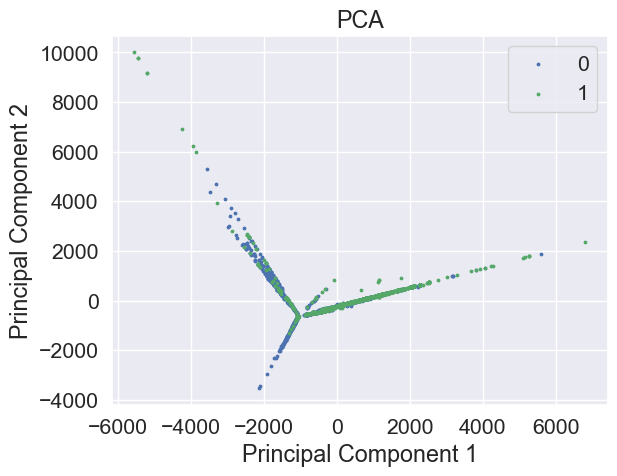

In [347]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

unique_labels = np.unique(Y_train)
colors = ['b', 'g']
for label, color in zip(unique_labels, colors):
    indices = np.where(Y_train == label)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=color, label=label, s=3)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()
plt.show()

Etant donné la répartition des fraudes et des non fraudes de façon radiale, on pense que le SVM le plus judicieux pour identifier les fraudes serait un SVM linéaire.

Source:

https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.kaggle.com%2Fcode%2Fresidentmario%2Fkernels-and-support-vector-machine-regularization&psig=AOvVaw1nBxj4CNa4yYgJiwXQSdEV&ust=1684165024156000&source=images&cd=vfe&ved=0CBEQjRxqFwoTCLChk-KR9f4CFQAAAAAdAAAAABAE![image.png](attachment:image.png)

# Modélisation

Dans cette partie, nous avons cherché à entrainer plusieur modèles:
    - Régression Logistique
    - Kmeans
    - SVM
    - Arbre de décision
    - Random forest
    - Voting soft classifier

## 1. Régression Logistique

On cherche à entrainer un modèle de régression logistique de sorte à avoir une pénalité optimale de la fonction de coût. C'est pourquoi on réalise une cross validation par grille. La cross validation va entrainer le modèle et sélectionner l'hyper-paramètre qui va maximiser le score PR-AUC.

In [348]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.metrics import make_scorer, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV

Y_train_df = pd.read_csv('Y_train_2_XPXJDyy.csv')
ids = Y_train_df.loc[Y_train.index, 'ID'].values

def pr_auc_scorer(y_true, y_pred, ids = ids):
    
    y_pred_df = pd.DataFrame()
    y_pred_df['ID'] = ids
    y_pred_df['y_pred'] = y_pred

    y_true_df = pd.DataFrame()
    y_true_df['ID'] = ids
    y_true_df['fraud_flag'] = y_true

    y_true_sorted = y_true_df.sort_values(by='ID').reset_index(drop=True)
    y_pred_sorted = y_pred_df.sort_values(by='ID').reset_index(drop=True)
    pr_auc_score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_sorted.iloc[:, 1]))
    
    return pr_auc_score

logistic_reg = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(logistic_reg, param_grid, refit = True, scoring=make_scorer(pr_auc_scorer), cv=5)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

y_train_true = np.array(Y_train['fraud_flag'].to_list())
y_test_true = np.array(Y_test['fraud_flag'].to_list())

train_pr_auc = pr_auc_scorer(y_train_true, y_train_pred)
test_pr_auc = pr_auc_scorer(y_test_true, y_test_pred, ids = Y_train_df.loc[Y_test.index, 'ID'].values)

print("Train PR AUC:", train_pr_auc)
print("Test PR AUC:", test_pr_auc)
print("Best Hyperparameters:", best_params)

Train PR AUC: 0.5586183759575069
Test PR AUC: 0.026413932521609815
Best Hyperparameters: {'C': 0.01}


L'hyper-paramètre retenu est 0.01.
La PR-AUC du Train Set et suppérieur à celle du Test Set, indiquant un overfitting. Cela vient certainement du fait que le Train Set qu'on a sous-échantillonné est plus petit que le Test Set.
Cependant, d'après l'ennoncé du challenge de BNP, 0.026 de PR-AUC montre qu'on arrive (légèrement) à prédire les fraudes, étant donné qu'une pédiction aléatoire a un PR-AUC de 0.015.
Ce faible PR-AUC est cohérent avec l'analyse que l'on a faite de l'ACP.

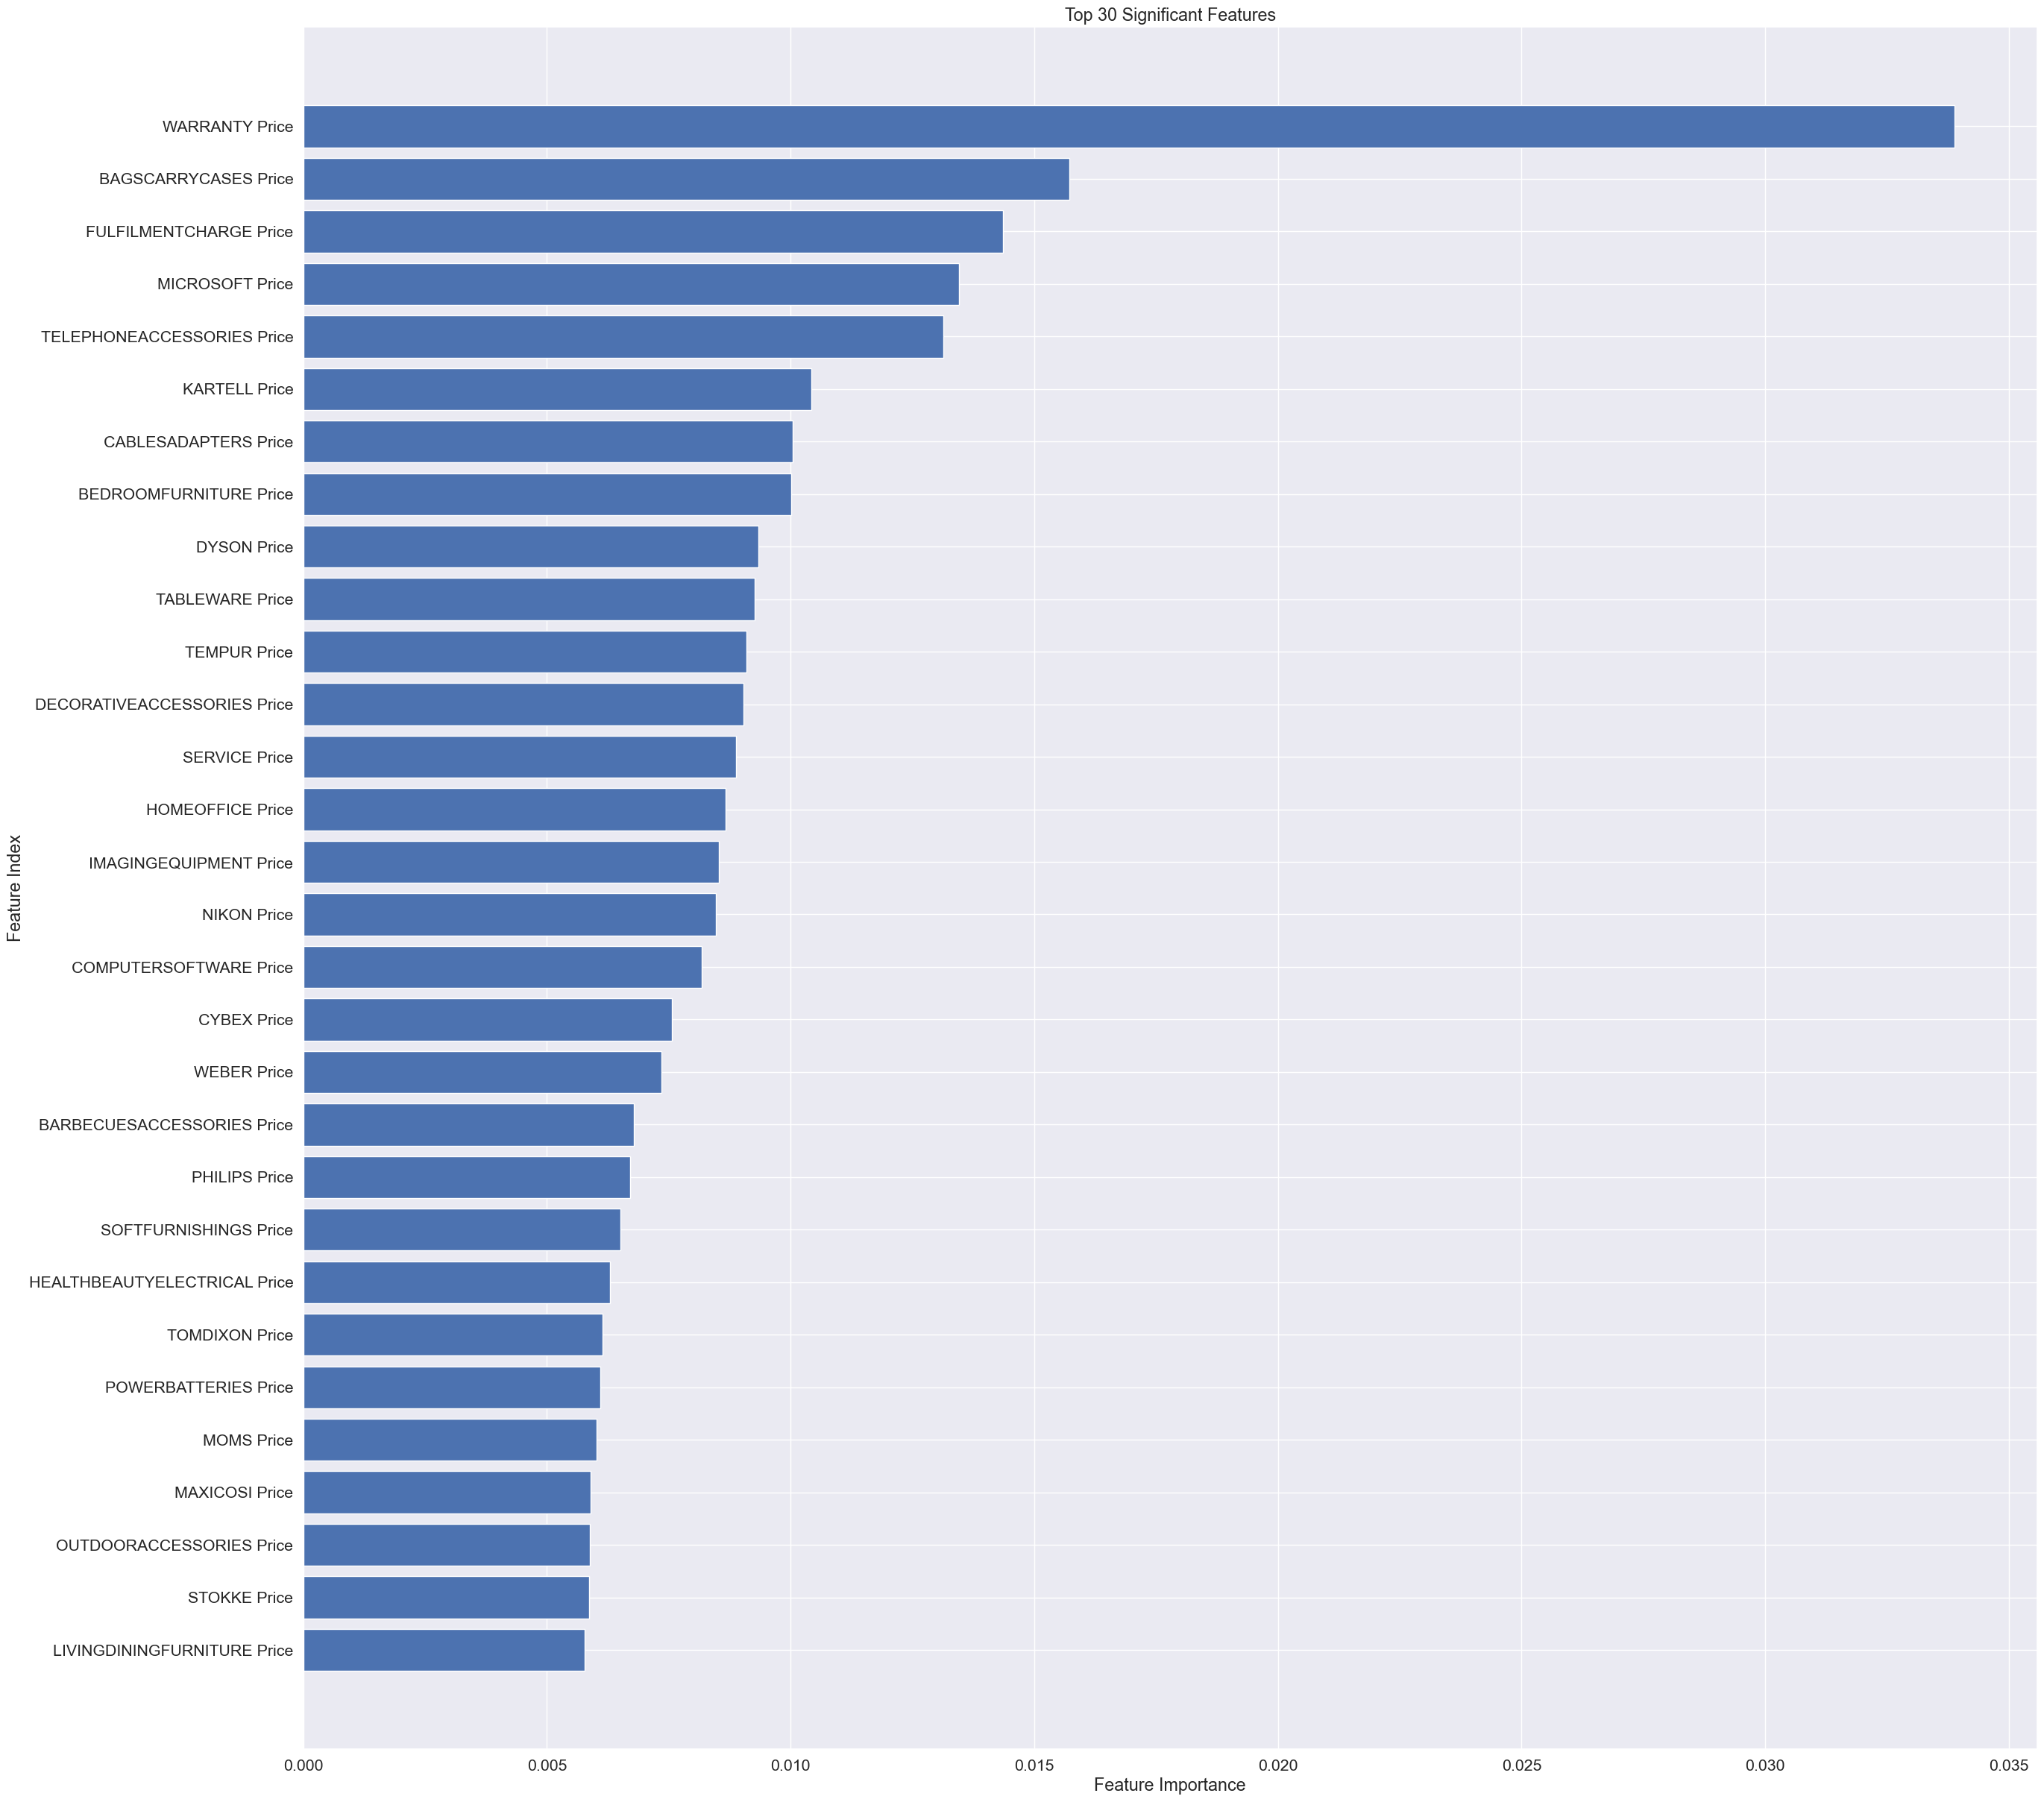

In [349]:
feature_importance = np.abs(grid_search.best_estimator_.coef_[0])
k = 30
top_k_indices = np.argsort(feature_importance)[-k:]
top_k_features = X_train.columns[top_k_indices]
top_k_importance = feature_importance[top_k_indices]

plt.figure(figsize=(30, 30))
plt.barh(range(len(top_k_features)), top_k_importance, align='center')
plt.yticks(range(len(top_k_features)), top_k_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Top {} Significant Features'.format(k))
plt.show()

En analysant les 30 features ayant le coeff de régression les plus grands en valeur absolue, on remarque que ce sont majoritairement les prix par marque et par item qui vont intervenir dans l'estimation de la probabilité de fraude. On remarque aussi, comme dans notre analyse préalable de données, que le fait d'avoir une garantie va être le facteur le plus déterminent pour la probabilité de fraude.

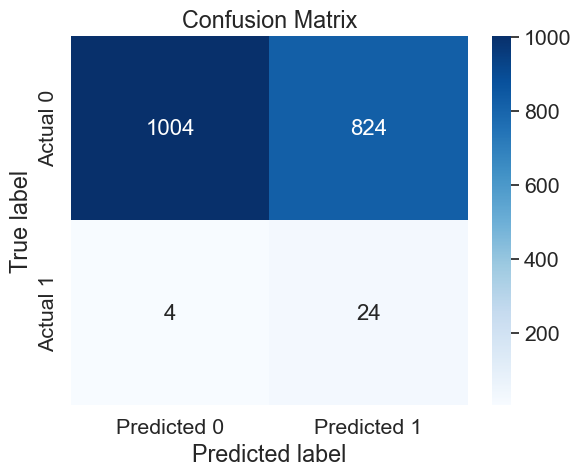

In [350]:
import seaborn as sns

def confusion_matrix(y_real, y_pred):
    P_true_1 = 0
    P_false_1 = 0
    P_true_0 = 0
    P_false_0 = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5 and y_real[i] == 1:
            P_true_1 += 1
        elif y_pred[i] < 0.5 and y_real[i] == 1:
            P_false_1 += 1
        elif y_pred[i] < 0.5 and y_real[i] == 0:
            P_true_0 += 1
        else:
            P_false_0 += 1

    confusion_matrix = np.array([[P_true_0, P_false_0], [P_false_1, P_true_1]])

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap="Blues",
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    
confusion_matrix(y_test_true, y_test_pred)

Certainement à cause de l'undersampling, on arrive mieux à prédire les fraudes que prédire les non-fraudes.

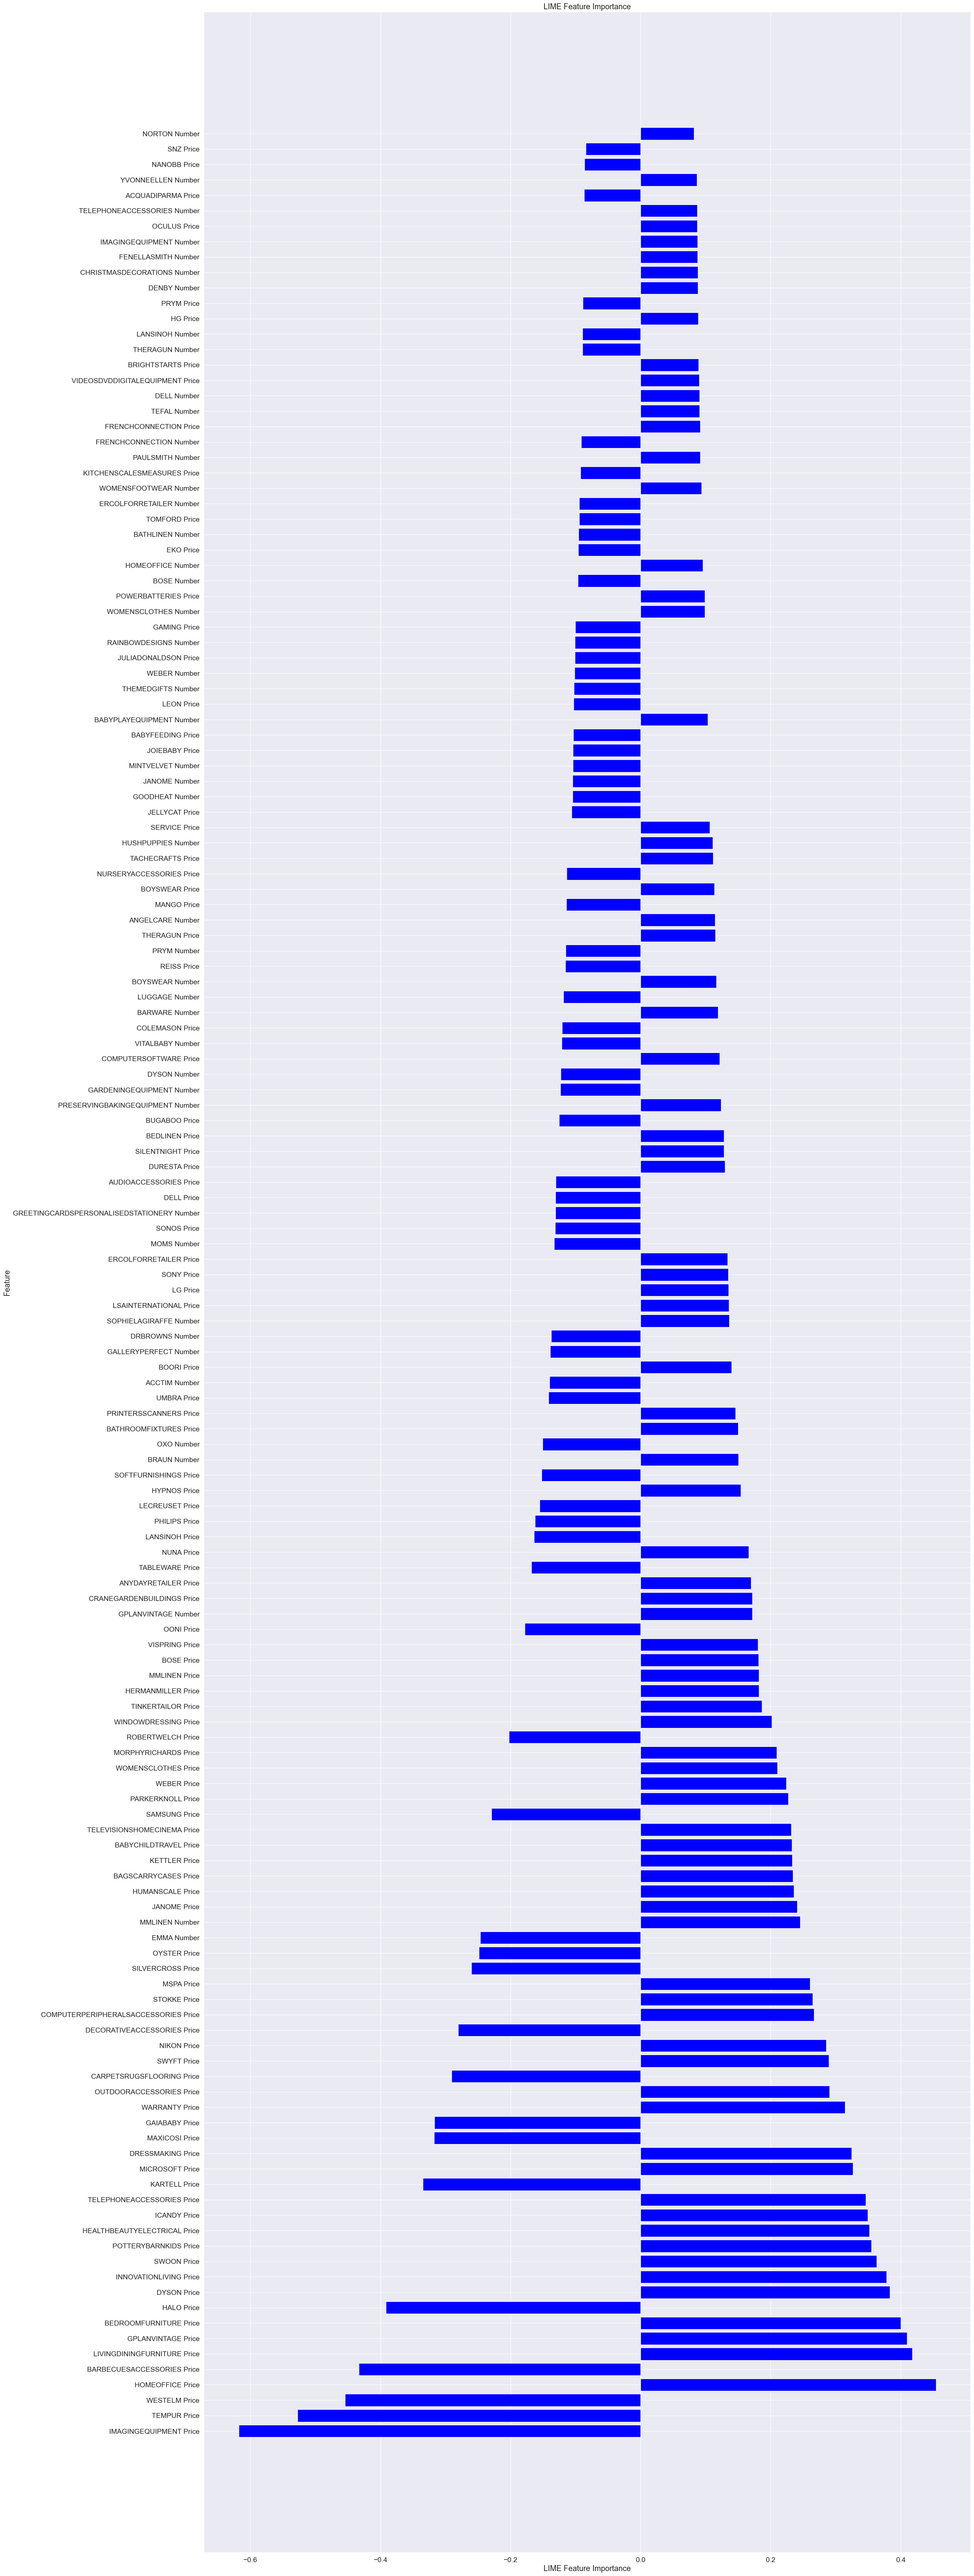

In [351]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)

instance_idx = 0
instance = X_test.iloc[instance_idx]

lime_explanation = explainer.explain_instance(instance.values, grid_search.best_estimator_.predict_proba, num_features=len(X_train.columns))

lime_feature_importance = lime_explanation.as_list()

lime_feature_names = [f[0].split(' <= 0.00')[0] for f in lime_feature_importance]
lime_feature_scores = [f[1] for f in lime_feature_importance]

plt.figure(figsize=(30, 100))
plt.barh(lime_feature_names[:150], lime_feature_scores[:150], color='blue')
plt.xlabel('LIME Feature Importance')
plt.ylabel('Feature')
plt.title('LIME Feature Importance')
plt.show()

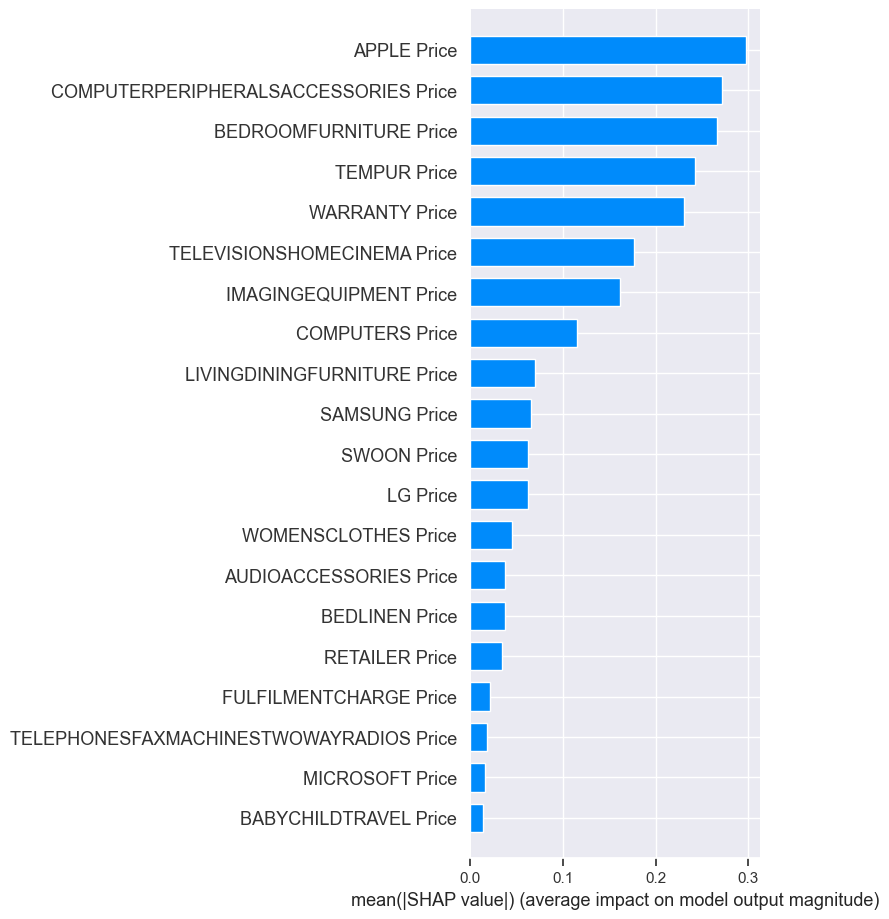

In [352]:
import shap

shap_explainer = shap.Explainer(grid_search.best_estimator_, X_train.values)

shap_values = shap_explainer.shap_values(instance.values)
shap_values_reshaped = shap_values.reshape(1, -1)

shap_feature_importance = np.abs(shap_values).mean(axis=0)

shap.summary_plot(shap_values_reshaped, X_test, feature_names=X_test.columns, plot_type='bar')

Les Lime et Shap viennent appuyer notre analyse à propos de l'importance des features. Les prix ont le plus fort pouvoir explicatif de la probabilité de fraude. On remarque aussi que le fait d'acheter de l'électroménager et fournitures de maison ou encore de contracter une garantie va plus influencer la probabilité de fraude (Dyson, Bedroom, Living furniture, Warranty...). En revanche lorqu'on regarde le diagramme du shap, le prix d'achetat d'un produit apple est la feature la plus influenceante en ce qui concerne la probabilité de fraude.

## 2.Clustering

In [353]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

kmeans = KMeans()

param_grid = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_search = GridSearchCV(kmeans, param_grid, refit = True, scoring=make_scorer(silhouette_scorer), cv=5)

grid_search.fit(X_train)

best_params = grid_search.best_params_

X_test_clusters = grid_search.predict(X_test)

df_test = X_test.copy()
df_test['Label'] = Y_test

print("Best Hyperparameter:", best_params)

for cluster_id in range(grid_search.best_params_['n_clusters']):
    cluster_samples = df_test[X_test_clusters == cluster_id]
    label_counts = cluster_samples['Label'].value_counts()
    print(f"Cluster {cluster_id} - Label distribution: ")
    print(label_counts)

Best Hyperparameter: {'n_clusters': 2}
Cluster 0 - Label distribution: 
0    819
1     22
Name: Label, dtype: int64
Cluster 1 - Label distribution: 
0    1009
1       6
Name: Label, dtype: int64


Dans notre modèle, il s'avère que le nombre optimal de cluster est de 2. On remarque que la fréquence de fraudes varie significativement entre les 2 clusters (le modèle arrive à dégager un profil dans lequel la probabilité de frauder est suppérieure). Les fréquences par cluster tendent à se rapprocher des la confusion matrix de la régression logistique. Cependant, on amène plus ou moins le modèle dans cette direction dans la mesure où on a échantillonné le modèle de sorte à ce qu'il y ait une proportion de fraudes plus grande par rapport au dataset initial, ce qui nous laisse penser que ces résultats ne sont pas forcément généralisables.

## 3.Sigmoid SVM

In [357]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

ids = Y_train_df.loc[Y_train.index, 'ID'].values

classifier = SVC(kernel='sigmoid', probability=True)

param_grid = {'C': [0.001, 0.01, 0.1]}

grid_search = GridSearchCV(classifier, param_grid, refit = True, scoring=make_scorer(pr_auc_scorer), cv=5)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

y_train_true = np.array(Y_train['fraud_flag'].to_list())
y_test_true = np.array(Y_test['fraud_flag'].to_list())

train_pr_auc = pr_auc_scorer(y_train_true, y_train_pred)
test_pr_auc = pr_auc_scorer(y_test_true, y_test_pred, ids = Y_train_df.loc[Y_test.index, 'ID'].values)

print("Train PR AUC:", train_pr_auc)
print("Test PR AUC:", test_pr_auc)
print("Best Hyperparameters:", best_params)

Train PR AUC: 0.3975977825685248
Test PR AUC: 0.015086206896551725
Best Hyperparameters: {'C': 0.001}


Le PR-AUC du 

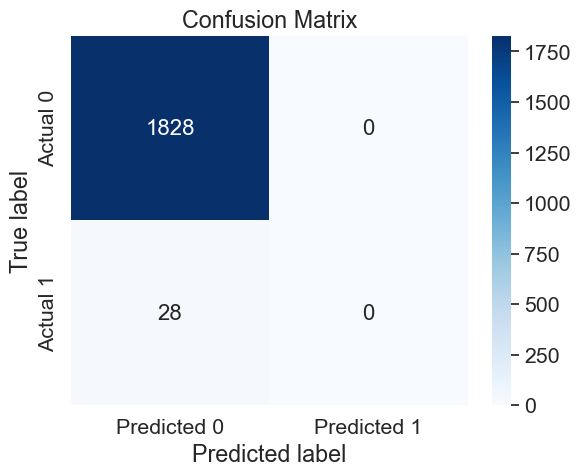

In [358]:
confusion_matrix(y_test_true, y_test_pred)

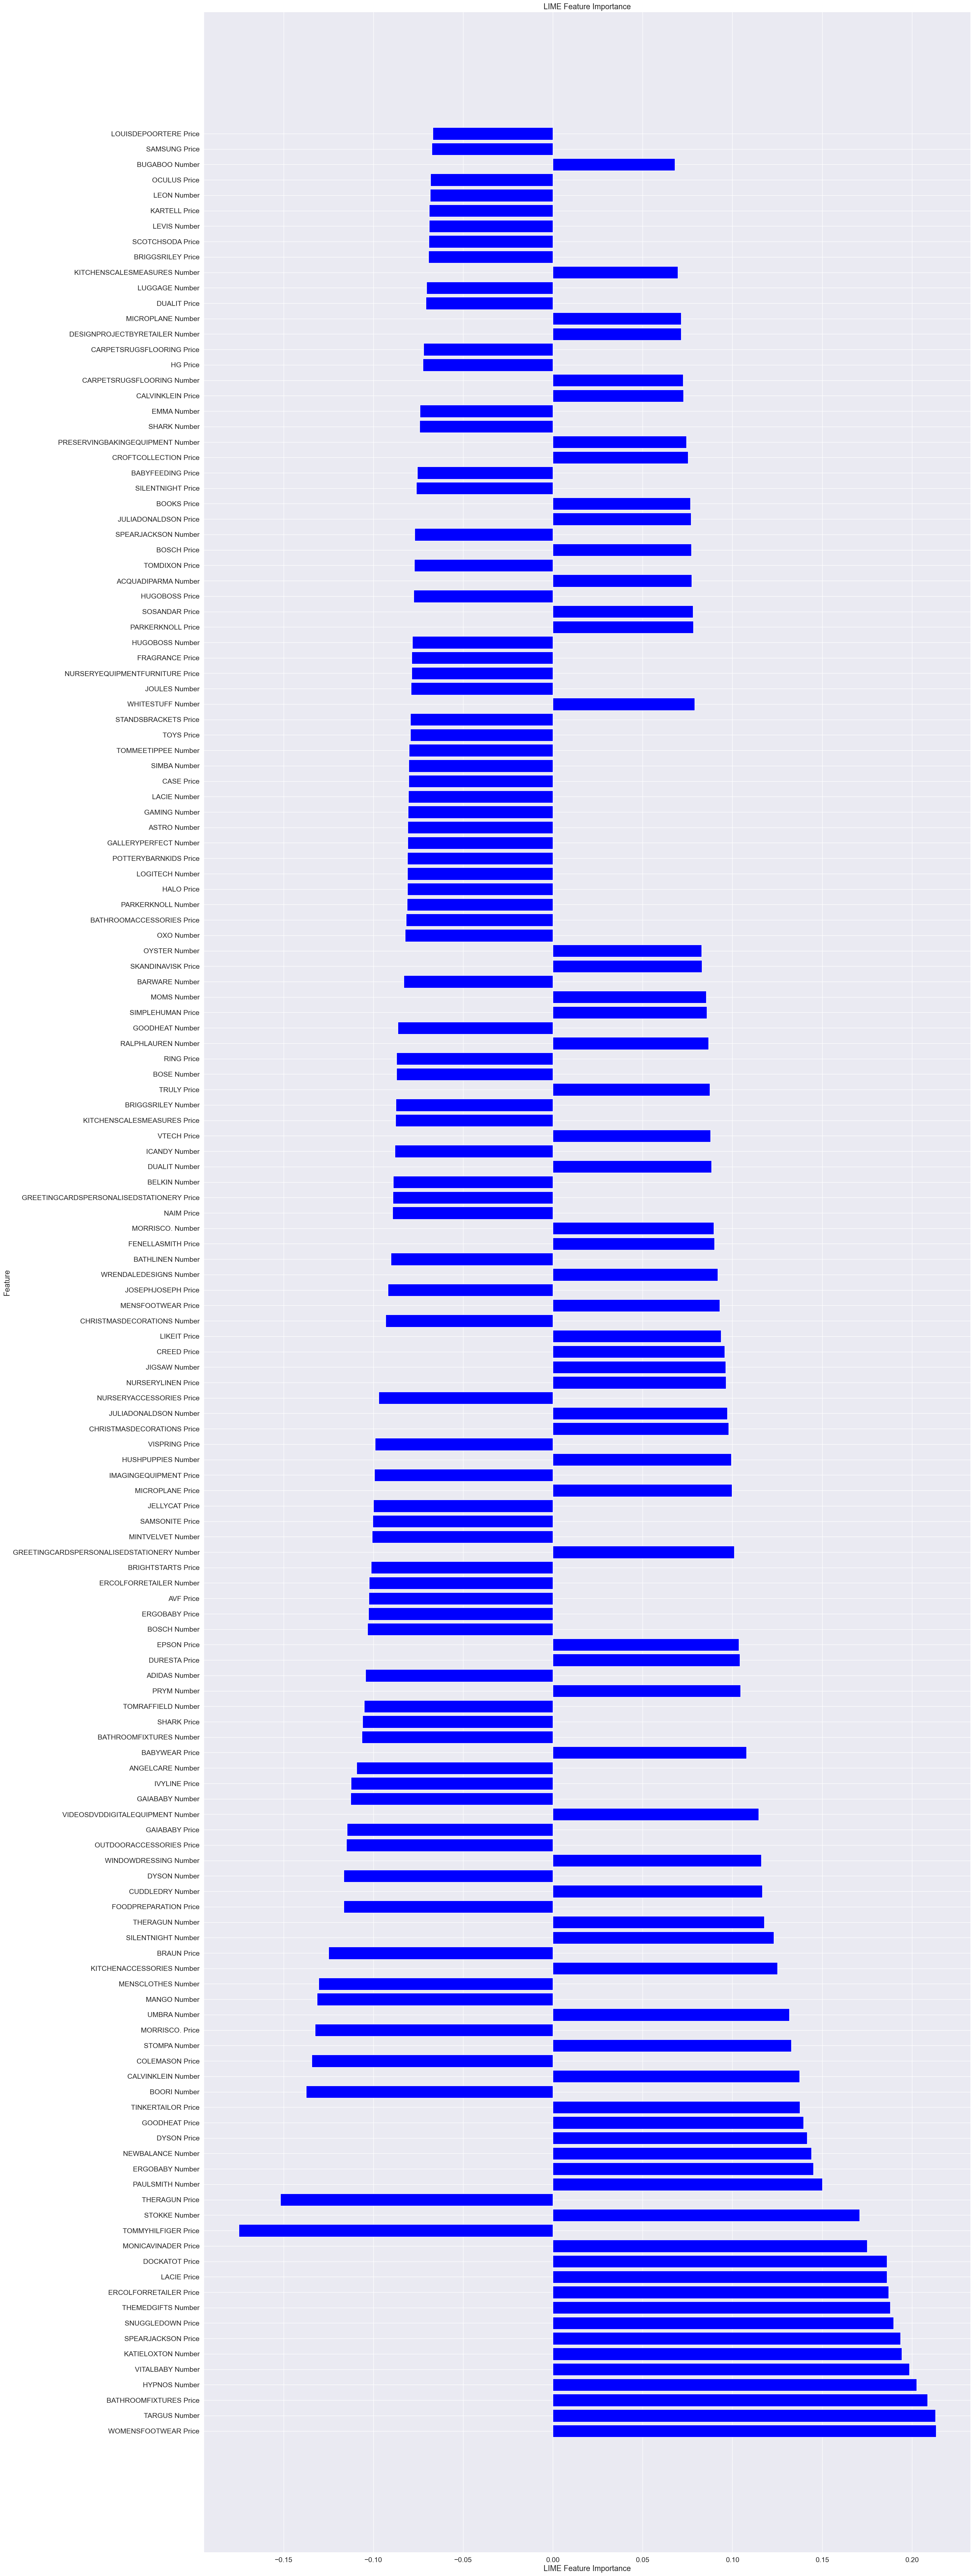

In [359]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)

instance_idx = 0
instance = X_test.iloc[instance_idx]

lime_explanation = explainer.explain_instance(instance.values, grid_search.best_estimator_.predict_proba, num_features=len(X_train.columns))

lime_feature_importance = lime_explanation.as_list()

lime_feature_names = [f[0].split(' <= 0.00')[0] for f in lime_feature_importance]
lime_feature_scores = [f[1] for f in lime_feature_importance]

plt.figure(figsize=(30, 100))
plt.barh(lime_feature_names[:150], lime_feature_scores[:150], color='blue')
plt.xlabel('LIME Feature Importance')
plt.ylabel('Feature')
plt.title('LIME Feature Importance')
plt.show()

Les résultats du SVM

## 4.Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, Y_train)

y_train_pred = tree_clf.predict(X_train)
y_test_pred = tree_clf.predict(X_test)

y_train_true = np.array(Y_train['fraud_flag'].to_list())
y_test_true = np.array(Y_test['fraud_flag'].to_list())

train_pr_auc = pr_auc_scorer(y_train_true, y_train_pred)
test_pr_auc = pr_auc_scorer(y_test_true, y_test_pred, ids = Y_train_df.loc[Y_test.index, 'ID'].values)

print("Train PR AUC:", train_pr_auc)
print("Test PR AUC:", test_pr_auc)

## 5.Random Forest

In [ ]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [ ]:
bag_clf.fit(X_train, Y_train)

y_train_pred = bag_clf.predict(X_train)
y_test_pred = bag_clf.predict(X_test)

y_train_true = np.array(Y_train['fraud_flag'].to_list())
y_test_true = np.array(Y_test['fraud_flag'].to_list())

train_pr_auc = pr_auc_scorer(y_train_true, y_train_pred)
test_pr_auc = pr_auc_scorer(y_test_true, y_test_pred, ids = Y_train_df.loc[Y_test.index, 'ID'].values)

print("Train PR AUC:", train_pr_auc)
print("Test PR AUC:", test_pr_auc)
print("Best Hyperparameters:", best_params)

## Test de cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

scores = cross_val_score(bag_clf, X_train, Y_train, cv=5)

print("Scores de validation croisée : ", scores)
print("Score moyen : ", np.mean(scores))
print("Écart-type : ", np.std(scores))

## 6.Voting soft classifer

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

svm_clf = SVC(kernel='rbf',gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, Y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)

    print(clf.__class__.__name__, accuracy_score(Y_test, y_pred))